# Assignment 4

**Submission deadline: last lab session before or on Wednesday, 22.11.17**

**Points: 11 + 4 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

In [7]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        """
        self.training=True
    
    def eval_mode(self):
        """Put layer into evalation mode.
        """
        self.training=False
    
    @property
    def parameters(self):
        return []
    

#zamiast polyaka tak tutaj lepiej go trzymac jak liste - tak jak velocities i miec boola ktory powie czy ich uzyc czy nie
class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = Variable(torch.FloatTensor(num_in, num_out),
                          requires_grad=True)
        self.W.name = 'W'
        self.b = Variable(torch.FloatTensor(1, num_out),
                          requires_grad=True)
        self.b.name = 'b'
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, x):
            return x.view(x.size(0), -1).mm(self.W) + self.b

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)


class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x)

class DropoutLayer(Layer):
    def __init__(self, p=0.5, inplace=False):
        self.p = p
        self.inplace = inplace       
    
    def forward(self,x):
        return F.dropout(x, self.p, self.training, self.inplace)

class MaxPool2Layer(Layer):
    def __init__(self, k_size=2):
        self.k_size=k_size
    
    def forward(self,x):
        return F.max_pool2d(x, self.k_size)

class ConvLayer(Layer):
    def __init__(self, in_channels, out_channels, k_size, padding=0, stride=1):
        self.W = Variable(torch.FloatTensor(out_channels, in_channels, k_size, k_size), requires_grad=True)
        self.W.name = 'W'
        self.b = Variable(torch.FloatTensor(out_channels), requires_grad=True)
        self.b.name = 'b'
        self.padding = padding
        self.stride = stride
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, x):
        return F.conv2d(input=x, weight=self.W, bias=self.b, stride=self.stride, padding=self.padding)

In [9]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    #what is this loss??
    def loss(self, outputs, targets):
        return torch.mean(-torch.log(torch.gather(
            outputs, 1, targets.unsqueeze(1))))

In [3]:
from sklearn import datasets
import torchvision


iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """Simple batch gradient descent"""
    try:
        old_loss = np.inf
        x = Variable(torch.from_numpy(x), requires_grad=False)
        y = Variable(torch.from_numpy(y.astype(np.int64)), requires_grad=False)
        model.train_mode()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            for p in model.parameters:
                p.data -= p.grad.data * alpha
                # Zero gradients for the next iteration
                p.grad.data.zero_()

            loss = loss.data[0]
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}%" \
                      .format(i, loss, err_rate)
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [10]:
model = FeedforwardNet(
    [AffineLayer(4, 1000),
     TanhLayer(),
     AffineLayer(1000, 3),
     SoftMaxLayer(),
    ])
distr = 0

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        if distr == 0:
            p.data.uniform_(-0.01, 0.01)/np.sqrt(p.data.numpy().shape[0])
        else:
            p.data.normal_(0, 0.01)/np.sqrt(p.data.numpy().shape[0])
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7)

Iteration      0 | loss  1.10 | err rate  59.33%
Iteration   1000 | loss  0.05 | err rate   2.00%
Iteration   2000 | loss  0.04 | err rate   2.00%
Iteration   3000 | loss  0.04 | err rate   1.33%
Iteration   4000 | loss  0.04 | err rate   1.33%
Iteration   5000 | loss  0.04 | err rate   1.33%
Tolerance level reached. Exiting.


In [22]:
p = Variable(torch.FloatTensor([[1, 2, 3], [4, 5, 6]]))
q = Variable(torch.FloatTensor(p.data))
q.data = torch.FloatTensor([[1, 2, 3], [4, 5, 9]])
print p,q
print p.view(1,2,3)
print p.size()

Variable containing:
 1  2  3
 4  5  6
[torch.FloatTensor of size 2x3]
 Variable containing:
 1  2  3
 4  5  9
[torch.FloatTensor of size 2x3]

Variable containing:
(0 ,.,.) = 
  1  2  3
  4  5  6
[torch.FloatTensor of size 1x2x3]

torch.Size([2, 3])


# Starter code for MNIST and SGD scaffolding

In [4]:
import torch
import torchvision


batch_size = 128
data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

In [5]:
def compute_error_rate(model, data_loader, cuda=False):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    if cuda:
        for p in model.parameters:
            p.data = p.data.cuda()
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        #x = Variable(x.view(x.size(0), -1), volatile=True)
        x = Variable(x, volatile=True)
        y = Variable(y, volatile=True)
        outputs = model.forward(x)
        _, predictions = outputs.data.max(dim=1)
        num_errs += (predictions != y.data).sum()
        num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, num_epochs=1, patience_expansion=1.5,
        log_every=100, cuda=False, alpha_c=0.99993, weight_lambda=0.0001, verbose=True, transform=None, polyak = 0.995):
    #Initialize momentum variables
    start_alpha = alpha
    velocities = [Variable(torch.FloatTensor(p.data.size()).zero_(), requires_grad=False) for p in model.parameters]
    polyaks = [Variable(torch.FloatTensor(p.data), requires_grad=False) for p in model.parameters]
    if cuda:
        #velocities = [(torch.from_numpy(np.zeros(p.data.numpy().shape, dtype="float32"))).cuda() for p in model.parameters]
        for p, v, pol in zip(model.parameters, velocities, polyaks):
            #print(type(p), type(v))
            p.data = p.data.cuda()
            v.data = v.data.cuda()
            pol.data = pol.data.cuda()
            
        
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    if verbose:
        print('Training the model!')
        print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                #x = Variable(x.view(x.size(0), -1), requires_grad=False)
                x = Variable(x, requires_grad=False)
                y = Variable(y, requires_grad=False)
                
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / out.size(0)

                history['train_losses'].append(loss.data[0])
                history['train_errs'].append(err_rate)

                for p, v, pol in zip(model.parameters, velocities, polyaks):
                    #polyak averaging
                    pol.data = polyak * pol.data + (1-polyak)*p.data
                    if p.name == 'W':
                        #Implement weight decay addition to gradients
                        p.grad.data += weight_lambda*p.data

                    #Update learning rate
                    alpha = start_alpha*alpha_c**iter_

                    #Set the momentum constant 
                    epsilon = 0.95
                    # Implement velocity update in momentum
                    v.data = epsilon*v.data + p.grad.data

                    #Set a more sensible learning rule here,
                    #using your learning rate schedule and momentum 
                    p.data -= alpha * v.data
                    # Zero gradients for the next iteration
                    p.grad.data.zero_()


                if iter_ % log_every == 0 and verbose:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}% | alpha = {3: > 5.4f}" \
                          .format(iter_, loss.data[0], err_rate, alpha)
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], cuda)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.clone().cpu() for p in model.parameters]
            if verbose:
                m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                    .format(epoch, val_err_rate, num_epochs, alpha)
                print '{0}\n{1}\n{0}'.format('-' * len(m), m)

    except KeyboardInterrupt:
        pass
    if best_params is not None and verbose:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    if polyak > 0:
        model.parameters = polyaks
    if verbose:
        plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.31 | err rate  9.38% | alpha =  0.0497
Minibatch    200  | loss  0.11 | err rate  3.91% | alpha =  0.0493
Minibatch    300  | loss  0.17 | err rate  3.91% | alpha =  0.0490
----------------------------------------------------------
After epoch  1 | valid err rate:  4.30% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.10 | err rate  3.12% | alpha =  0.0486
Minibatch    500  | loss  0.14 | err rate  3.91% | alpha =  0.0483
Minibatch    600  | loss  0.11 | err rate  2.34% | alpha =  0.0479
Minibatch    700  | loss  0.03 | err rate  0.78% | alpha =  0.0476
----------------------------------------------------------
After epoch  2 | valid err rate:  2.88% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.04 | err rate  2.34% | alpha =  0.0473
Minibatch    900  | lo

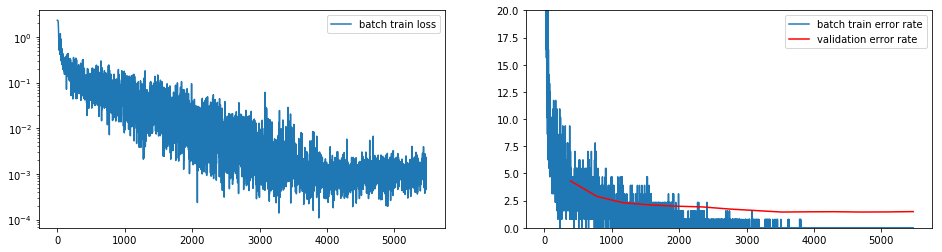

In [24]:
# TODO: Pick a network architecture here.
num_hidden = 3000
distr = 0
w = 0.001
model = FeedforwardNet(
    [
     AffineLayer(784, num_hidden),
     ReLULayer(),
     AffineLayer(num_hidden, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        if distr == 0:
            p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
        else:
            p.data.normal_(0, w)/np.sqrt(p.data.numpy().shape[0])
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=5*1e-2, cuda=True, patience_expansion=1.5)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], cuda=True)

Looking for good values of the parameters (including task 3)

In [ ]:
weight_c = np.array([1,0.1,0.01])
num_hidden_p = np.array([500,1500,2500,3500,4500])
alpha_c = np.array([1e-1, 5*1e-2, 1e-2])
alpha_con = np.array([0.9999, 0.99993, 0.99996, 0.99999])
lambdas = np.array([0.01, 0.001, 0.0001])
#distr = ['u','n']
best_err = 100.0
#best_params = []
max_iter = 300

for i in range(max_iter):
    w = np.random.uniform(0.001, 0.009)
    num_hidden = 500*np.random.randint(1,10)
    alpha = np.random.uniform(0.01, 0.1)
    alp = np.random.uniform(0.9999, 0.99999)
    lam = 10**np.random.randint(-5,-1)
    distr = np.random.randint(0,2)
    if(distr == 0):
        dd = 'uniform'
    else:
        dd = 'normal'
    prob = np.random.uniform(0.0,0.8)
    
    print 'Start iter '+ str(i) + ' with params: w = '+ str(w)+ ', num_hidden = ' + str(num_hidden)+ ', alpha = ' + str(alpha) + ', distribution = ' + dd + ', learning rate = ' +str(alp) + ', weight decay = ' + str(lam) + ', dropout prob = ' + str(prob)
    model = FeedforwardNet(
        [
         AffineLayer(784, num_hidden),
         DropoutLayer(p=prob),
         ReLULayer(),
         AffineLayer(num_hidden, 10),
         SoftMaxLayer()
        ])

    # Initialize parameters
    for p in model.parameters:
        if p.name == 'W':
            if distr == 0:
                p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
            else:
                p.data.normal_(0, w)/np.sqrt(p.data.numpy().shape[0])
        elif p.name == 'b':
            p.data.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

    # On lab computers you can set cuda=True !
    SGD(model, mnist_loaders, alpha=alpha, cuda=True, patience_expansion=0, num_epochs=50, log_every=100000, alpha_c=alp, weight_lambda=lam, verbose=False)
    err = compute_error_rate(model, mnist_loaders['test'], cuda=True)
    if(err < best_err):
        best_err = err
        #print best_err, w, num_hidden, alpha, distr, alp, lam, prob, i
        best_params = np.array([best_err, w, num_hidden, alpha, distr, alp, lam, prob, i], dtype="float32")
        print best_params
        np.savetxt('assignment4.out', best_params, fmt="%.6f")

Start iter 0 with params: w = 0.00288961574661, num_hidden = 2500, alpha = 0.0413143697865, distribution = normal, learning rate = 0.999925544361, weight decay = 0.001, dropout prob = 0.47085816286
[  1.53999996e+00   2.88961572e-03   2.50000000e+03   4.13143709e-02
   1.00000000e+00   9.99925554e-01   1.00000005e-03   4.70858157e-01
   0.00000000e+00]
Start iter 1 with params: w = 0.0087318894755, num_hidden = 4000, alpha = 0.0222319565469, distribution = uniform, learning rate = 0.999989001155, weight decay = 0.0001, dropout prob = 0.0954983957264
[  1.47000003e+00   8.73188954e-03   4.00000000e+03   2.22319569e-02
   0.00000000e+00   9.99988973e-01   9.99999975e-05   9.54983979e-02
   1.00000000e+00]
Start iter 2 with params: w = 0.00213257357169, num_hidden = 3500, alpha = 0.0216872585174, distribution = normal, learning rate = 0.999960670587, weight decay = 1e-05, dropout prob = 0.767799390834
Start iter 3 with params: w = 0.00355145561229, num_hidden = 4500, alpha = 0.05343272842

In [ ]:
#big_network
best_err = 100.0
#best_params = []
max_iter = 500

for i in range(max_iter):
    w = np.random.uniform(0.001, 0.009)
    num_hidden = 500*np.random.randint(1,5)
    num_hidden2 = 500*np.random.randint(1,5)
    num_hidden3 = 500*np.random.randint(1,5)
    alpha = np.random.uniform(0.01, 0.1)
    alp = np.random.uniform(0.9999, 0.99999)
    lam = 10**np.random.randint(-5,-1)
    distr = np.random.randint(0,2)
    if(distr == 0):
        dd = 'uniform'
    else:
        dd = 'normal'
    prob = np.random.uniform(0.0,0.8)
    
    print 'Start iter '+ str(i) + ' with params: w = '+ str(w)+ ', num_hidden = ' + str(num_hidden)+ ', alpha = ' + str(alpha) + ', distribution = ' + dd + ', learning rate = ' +str(alp) + ', weight decay = ' + str(lam) + ', dropout prob = ' + str(prob)
    model = FeedforwardNet(
        [
         AffineLayer(784, num_hidden),
         DropoutLayer(p=prob),
         ReLULayer(),
         AffineLayer(num_hidden, num_hidden2),
         DropoutLayer(p=prob),
         ReLULayer(),
         AffineLayer(num_hidden2, num_hidden3),
         DropoutLayer(p=prob),
         ReLULayer(),
         AffineLayer(num_hidden3, 10),
         SoftMaxLayer()
        ])

    # Initialize parameters
    for p in model.parameters:
        if p.name == 'W':
            if distr == 0:
                p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
            else:
                p.data.normal_(0, w)/np.sqrt(p.data.numpy().shape[0])
        elif p.name == 'b':
            p.data.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

    # On lab computers you can set cuda=True !
    SGD(model, mnist_loaders, alpha=alpha, cuda=True, patience_expansion=0, num_epochs=50, log_every=100000, alpha_c=alp, weight_lambda=lam, verbose=False)
    err = compute_error_rate(model, mnist_loaders['test'], cuda=True)
    if(err < best_err):
        best_err = err
        #print best_err, w, num_hidden, alpha, distr, alp, lam, prob, i
        best_params = np.array([best_err, w, num_hidden, num_hidden2, num_hidden3, alpha, distr, alp, lam, prob, i], dtype="float32")
        print best_params
        np.savetxt('assignment4big.out', best_params, fmt="%.6f")

Start iter 0 with params: w = 0.0061796381235, num_hidden = 500, alpha = 0.0837400682776, distribution = normal, learning rate = 0.999986884431, weight decay = 0.001, dropout prob = 0.466556014256
[  8.86500015e+01   6.17963821e-03   5.00000000e+02   5.00000000e+02
   1.50000000e+03   8.37400705e-02   1.00000000e+00   9.99986887e-01
   1.00000005e-03   4.66556013e-01   0.00000000e+00]
Start iter 1 with params: w = 0.00263981495041, num_hidden = 500, alpha = 0.0484458414494, distribution = normal, learning rate = 0.999962676631, weight decay = 0.0001, dropout prob = 0.114614590505
[  1.38000000e+00   2.63981498e-03   5.00000000e+02   1.00000000e+03
   1.00000000e+03   4.84458432e-02   1.00000000e+00   9.99962687e-01
   9.99999975e-05   1.14614591e-01   1.00000000e+00]
Start iter 2 with params: w = 0.00253165405936, num_hidden = 1500, alpha = 0.0651465780795, distribution = normal, learning rate = 0.999935878955, weight decay = 0.0001, dropout prob = 0.342094522677
[  1.36000001e+00   2.

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.38 | err rate 14.06% | alpha =  0.0579
Minibatch    200  | loss  0.14 | err rate  5.47% | alpha =  0.0576
Minibatch    300  | loss  0.24 | err rate  7.03% | alpha =  0.0574
----------------------------------------------------------
After epoch  1 | valid err rate:  4.80% | doing  50 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.28 | err rate  9.38% | alpha =  0.0571
Minibatch    500  | loss  0.10 | err rate  3.12% | alpha =  0.0568
Minibatch    600  | loss  0.26 | err rate  5.47% | alpha =  0.0565
Minibatch    700  | loss  0.20 | err rate  7.81% | alpha =  0.0563
----------------------------------------------------------
After epoch  2 | valid err rate:  3.87% | doing  50 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.13 | err rate  3.12% | alpha =  0.0560
Minibatch    900  | lo

----------------------------------------------------------
After epoch 19 | valid err rate:  1.79% | doing  50 epochs
----------------------------------------------------------
Minibatch   7500  | loss  0.02 | err rate  0.78% | alpha =  0.0406
Minibatch   7600  | loss  0.00 | err rate  0.00% | alpha =  0.0404
Minibatch   7700  | loss  0.02 | err rate  0.78% | alpha =  0.0402
Minibatch   7800  | loss  0.03 | err rate  0.78% | alpha =  0.0400
----------------------------------------------------------
After epoch 20 | valid err rate:  1.73% | doing  50 epochs
----------------------------------------------------------
Minibatch   7900  | loss  0.03 | err rate  1.56% | alpha =  0.0398
Minibatch   8000  | loss  0.00 | err rate  0.00% | alpha =  0.0396
Minibatch   8100  | loss  0.03 | err rate  0.78% | alpha =  0.0394
Minibatch   8200  | loss  0.02 | err rate  0.78% | alpha =  0.0393
----------------------------------------------------------
After epoch 21 | valid err rate:  1.69% | doing  50

Minibatch  14800  | loss  0.00 | err rate  0.00% | alpha =  0.0286
----------------------------------------------------------
After epoch 38 | valid err rate:  1.35% | doing  50 epochs
----------------------------------------------------------
Minibatch  14900  | loss  0.00 | err rate  0.00% | alpha =  0.0285
Minibatch  15000  | loss  0.00 | err rate  0.00% | alpha =  0.0283
Minibatch  15100  | loss  0.01 | err rate  0.78% | alpha =  0.0282
Minibatch  15200  | loss  0.01 | err rate  0.00% | alpha =  0.0281
----------------------------------------------------------
After epoch 39 | valid err rate:  1.47% | doing  50 epochs
----------------------------------------------------------
Minibatch  15300  | loss  0.01 | err rate  0.00% | alpha =  0.0279
Minibatch  15400  | loss  0.01 | err rate  0.00% | alpha =  0.0278
Minibatch  15500  | loss  0.00 | err rate  0.00% | alpha =  0.0277
Minibatch  15600  | loss  0.00 | err rate  0.00% | alpha =  0.0275
-------------------------------------------

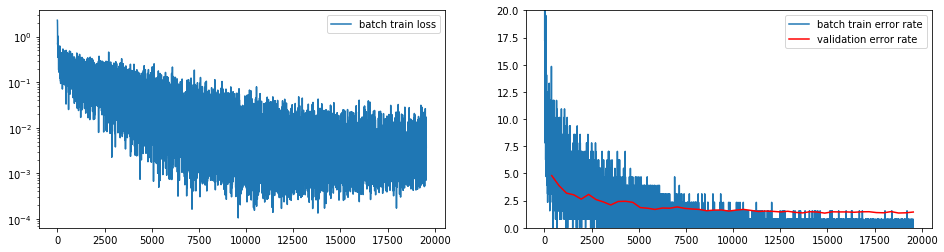

In [11]:
#good values of the parameters found by script above
w = 0.004145
num_hidden = 2000
alpha = 0.058186
distr = 0 
alp = 0.999952
lam = 0.000100
prob = 0.320057
model = FeedforwardNet(
        [
         AffineLayer(784, num_hidden),
         DropoutLayer(p=prob),
         ReLULayer(),
         AffineLayer(num_hidden, 10),
         SoftMaxLayer()
        ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        if distr == 0:
            p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
        else:
            p.data.normal_(0, w)/np.sqrt(p.data.numpy().shape[0])
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=alpha, cuda=True, patience_expansion=0, num_epochs=50, alpha_c=alp, weight_lambda=lam)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], cuda=True)

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Instead of using transforms it would be better to write rotation and addition of noise by yourself

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.36 | err rate  9.38% | alpha =  0.0520
Minibatch    200  | loss  0.31 | err rate  8.59% | alpha =  0.0517
Minibatch    300  | loss  0.20 | err rate  6.25% | alpha =  0.0513
----------------------------------------------------------
After epoch  1 | valid err rate:  3.21% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.13 | err rate  4.69% | alpha =  0.0509
Minibatch    500  | loss  0.21 | err rate  3.91% | alpha =  0.0506
Minibatch    600  | loss  0.23 | err rate  7.03% | alpha =  0.0502
Minibatch    700  | loss  0.22 | err rate  8.59% | alpha =  0.0499
----------------------------------------------------------
After epoch  2 | valid err rate:  2.73% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.17 | err rate  5.47% | alpha =  0.0495
Minibatch    900  | lo

----------------------------------------------------------
After epoch 19 | valid err rate:  1.68% | doing  21 epochs
----------------------------------------------------------
Minibatch   7500  | loss  0.00 | err rate  0.00% | alpha =  0.0310
Minibatch   7600  | loss  0.05 | err rate  2.34% | alpha =  0.0308
Minibatch   7700  | loss  0.02 | err rate  1.56% | alpha =  0.0306
Minibatch   7800  | loss  0.04 | err rate  1.56% | alpha =  0.0304
----------------------------------------------------------
After epoch 20 | valid err rate:  1.67% | doing  21 epochs
----------------------------------------------------------
Minibatch   7900  | loss  0.03 | err rate  0.78% | alpha =  0.0301
Minibatch   8000  | loss  0.03 | err rate  0.78% | alpha =  0.0299
Minibatch   8100  | loss  0.01 | err rate  0.78% | alpha =  0.0297
Minibatch   8200  | loss  0.04 | err rate  1.56% | alpha =  0.0295
----------------------------------------------------------
After epoch 21 | valid err rate:  1.51% | doing  34

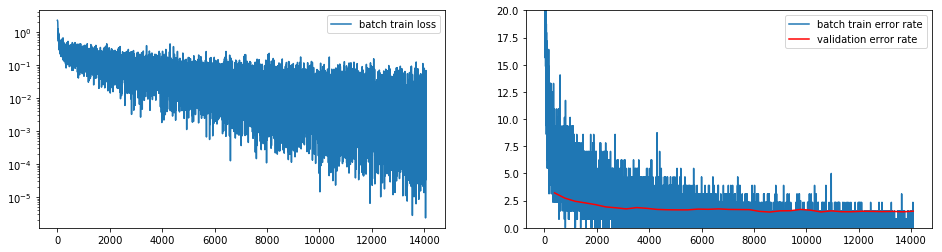

In [12]:
#good values of the parameters found by script above
w = 0.026345
num_hidden = 2000
alpha = 0.052396
alp = 0.99993
lam = 0.00001
distr = 0 
prob = 0.4
model = FeedforwardNet(
        [
         AffineLayer(784, num_hidden),
         DropoutLayer(p=prob),
         ReLULayer(),
         AffineLayer(num_hidden, 1000),
         DropoutLayer(p=prob),
         ReLULayer(), 
         AffineLayer(1000, 500),
         DropoutLayer(p=prob),
         ReLULayer(), 
         AffineLayer(500, 10),
         SoftMaxLayer()
        ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        if distr == 0:
            p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
        else:
            p.data.normal_(0, w)/np.sqrt(p.data.numpy().shape[0])
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=alpha, cuda=True, patience_expansion=1.6, alpha_c=alp, weight_lambda=lam)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], cuda=True)

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.89 | err rate 23.44% | alpha =  0.0590
Minibatch    200  | loss  0.28 | err rate  6.25% | alpha =  0.0587
Minibatch    300  | loss  0.19 | err rate  6.25% | alpha =  0.0585
----------------------------------------------------------
After epoch  1 | valid err rate:  3.01% | doing  50 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.11 | err rate  3.91% | alpha =  0.0582
Minibatch    500  | loss  0.13 | err rate  4.69% | alpha =  0.0579
Minibatch    600  | loss  0.05 | err rate  2.34% | alpha =  0.0576
Minibatch    700  | loss  0.09 | err rate  3.91% | alpha =  0.0574
----------------------------------------------------------
After epoch  2 | valid err rate:  2.75% | doing  50 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.12 | err rate  3.91% | alpha =  0.0571
Minibatch    900  | lo

----------------------------------------------------------
After epoch 19 | valid err rate:  1.60% | doing  50 epochs
----------------------------------------------------------
Minibatch   7500  | loss  0.07 | err rate  1.56% | alpha =  0.0417
Minibatch   7600  | loss  0.02 | err rate  0.78% | alpha =  0.0415
Minibatch   7700  | loss  0.02 | err rate  0.78% | alpha =  0.0413
Minibatch   7800  | loss  0.04 | err rate  1.56% | alpha =  0.0411
----------------------------------------------------------
After epoch 20 | valid err rate:  1.75% | doing  50 epochs
----------------------------------------------------------
Minibatch   7900  | loss  0.01 | err rate  0.78% | alpha =  0.0409
Minibatch   8000  | loss  0.00 | err rate  0.00% | alpha =  0.0407
Minibatch   8100  | loss  0.06 | err rate  1.56% | alpha =  0.0405
Minibatch   8200  | loss  0.01 | err rate  0.78% | alpha =  0.0403
----------------------------------------------------------
After epoch 21 | valid err rate:  1.53% | doing  50

Minibatch  14800  | loss  0.00 | err rate  0.00% | alpha =  0.0296
----------------------------------------------------------
After epoch 38 | valid err rate:  1.15% | doing  50 epochs
----------------------------------------------------------
Minibatch  14900  | loss  0.00 | err rate  0.00% | alpha =  0.0294
Minibatch  15000  | loss  0.00 | err rate  0.00% | alpha =  0.0293
Minibatch  15100  | loss  0.00 | err rate  0.00% | alpha =  0.0292
Minibatch  15200  | loss  0.00 | err rate  0.00% | alpha =  0.0290
----------------------------------------------------------
After epoch 39 | valid err rate:  1.24% | doing  50 epochs
----------------------------------------------------------
Minibatch  15300  | loss  0.01 | err rate  0.00% | alpha =  0.0289
Minibatch  15400  | loss  0.00 | err rate  0.00% | alpha =  0.0287
Minibatch  15500  | loss  0.00 | err rate  0.00% | alpha =  0.0286
Minibatch  15600  | loss  0.00 | err rate  0.00% | alpha =  0.0285
-------------------------------------------

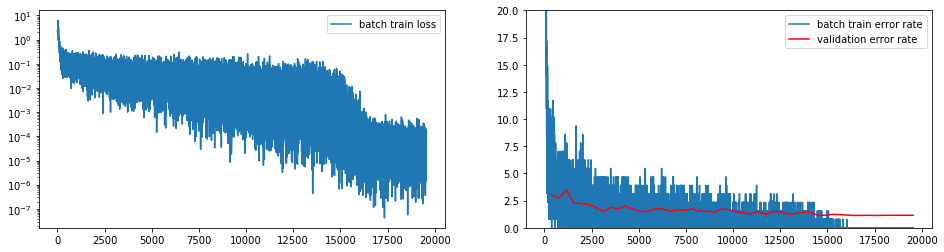

In [11]:
#good values of the parameters found by script above
w = 0.003897
alpha = 0.059289
alp = 0.999953
lam = 0.000010
model = FeedforwardNet(
        [
         ConvLayer(in_channels=1,out_channels=32,k_size=5,padding=2),
         ReLULayer(),
         MaxPool2Layer(),
         ConvLayer(in_channels=32, out_channels=64, k_size=5, padding=2),
         ReLULayer(),
         MaxPool2Layer(),
         AffineLayer(7*7*64, 10),
         SoftMaxLayer()
        ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
         p.data.uniform_(-w, w)/np.sqrt(p.size()[0])
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=alpha, cuda=False, patience_expansion=0, num_epochs=50, alpha_c=alp, weight_lambda=lam)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], cuda=False)

In [ ]:
best_err = 100.0
#best_params = []
max_iter = 300

for i in range(max_iter):
    w = np.random.uniform(0.001, 0.009)
    alpha = np.random.uniform(0.01, 0.1)
    alp = np.random.uniform(0.9999, 0.99999)
    lam = 10**np.random.randint(-5,-1)
    
    print 'Start iter '+ str(i) + ' with params: w = '+ str(w)+ ', alpha = ' + str(alpha) + ', learning rate = ' +str(alp) + ', weight decay = ' + str(lam)
    model = FeedforwardNet(
        [
         ConvLayer(in_channels=1,out_channels=32,k_size=5,padding=2),
         ReLULayer(),
         MaxPool2Layer(),
         ConvLayer(in_channels=32, out_channels=64, k_size=5, padding=2),
         ReLULayer(),
         MaxPool2Layer(),
         AffineLayer(7*7*64, 10),
         SoftMaxLayer()
        ])

    # Initialize parameters
    for p in model.parameters:
        if p.name == 'W':
            p.data.uniform_(-w, w)/np.sqrt(p.data.numpy().shape[0])
        elif p.name == 'b':
            p.data.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

    # On lab computers you can set cuda=True !
    SGD(model, mnist_loaders, alpha=alpha, cuda=False, patience_expansion=0, num_epochs=25, log_every=100000, alpha_c=alp, weight_lambda=lam, verbose=False)
    err = compute_error_rate(model, mnist_loaders['test'], cuda=False)
    if(err < best_err):
        best_err = err
        #print best_err, w, num_hidden, alpha, distr, alp, lam, prob, i
        best_params = np.array([best_err, w, alpha, alp, lam, i], dtype="float32")
        print best_params
        np.savetxt('assignment4conv.out', best_params, fmt="%.6f")

Start iter 0 with params: w = 0.00389658517072, alpha = 0.0592885072117, learning rate = 0.999952977462, weight decay = 1e-05


# Problem 8: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

Implemented in task3